In [1]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model 

model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/flexible_models_best_FP/r0_r2_FP_trial_2/")

hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




In [3]:
checkpoint_path = model_path / "checkpoints/epoch=42-all_inputs.ckpt"

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
model.change_ranker_for_testing()
# model.change_ranker_for_inference()

Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [4]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

In [5]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))

smiles_and_names = [(index_to_smiles[file_index], index_to_chemical_names[file_index]) for file_index in sorted_file_indices]
len(smiles_and_names)


3881

In [6]:
len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

(3881, 3881, 3881)

In [7]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [8]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename)

Chemspider_Pyristriatin A
COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
10022.pt


In [9]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C',
 'Chemspider_Pyristriatin A')

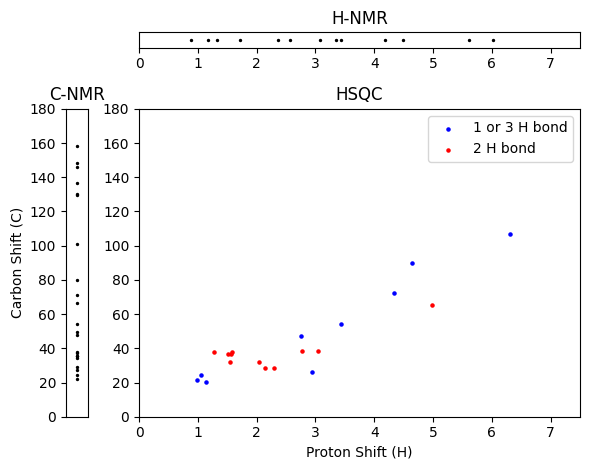

In [10]:
import matplotlib.pyplot as plt




# 
import matplotlib.gridspec as gridspec


# Create a 2x2 grid for subplots
fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

# Create subplots in different locations and sizes
pos = hsqc[hsqc[:,2]>0]
neg = hsqc[hsqc[:,2]<0]
ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
ax1.set_title("HSQC")
ax1.set_xlabel('Proton Shift (H)')  # X-axis label
ax1.set_xlim([0, 7.5])
ax1.set_ylim([0, 180])
ax1.legend()


ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
ax2.set_ylim([0, 180])
ax2.set_title("C-NMR")
ax2.set_ylabel('Carbon Shift (C)')
ax2.set_xticks([])

ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
ax3.set_xlim([0, 7.5])
ax3.set_title("H-NMR")
ax3.set_yticks([])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()



_________________________________________________________
Chemical name METHYL GALACTOSIDE
Ground truth smiles COC1OC(CO)C(O)C(O)C1O


/root/MorganFP_prediction/reproduce_previous_works/smart4.5/utils/ranker.py:88: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  query_products = (self.data @ query.T.squeeze(2))


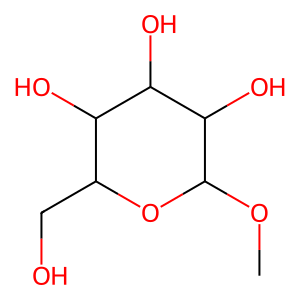

retival #1
HSQC smiles COC1OC(CO)C(O)C(O)C1O
HSQC name METHYL GALACTOSIDE


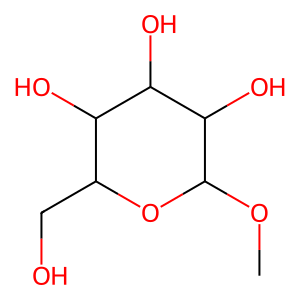

retival #2
HSQC smiles CCCCCCCCOC1OC(CO)C(O)C(O)C1O
HSQC name NCGC00385963-01!(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-octoxyoxane-3,4,5-triol


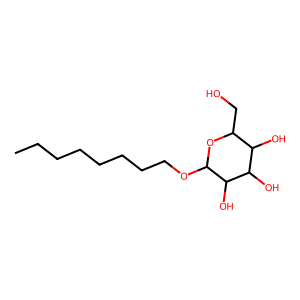

retival #3
HSQC smiles COc1cc(CO)ccc1OC1OC(CO)C(O)C(O)C1O
HSQC name Vanilloloside


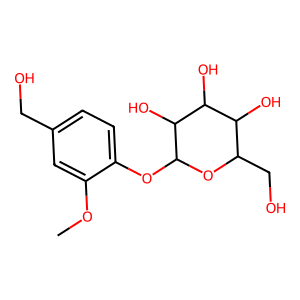

retival #4
HSQC smiles CC(=O)OCC(O)COC1OC(CO)C(O)C(O)C1O
HSQC name 92122-76-4


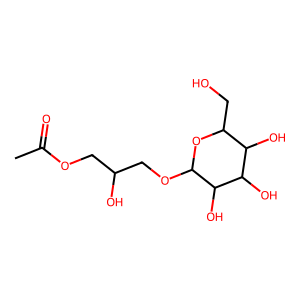

retival #5
HSQC smiles COC1C2C=COC(OC3OC(CO)C(O)C(O)C3O)C2C2(CO)OC12
HSQC name (2R,3S,4R,5R,6S)-2-[[(1As,1Bs,2S,5Ar,6S,6As)-1A-(Hydroxymethyl)-6-Methoxy-2,5A,6,6A-Tetrahydro-1Bh-Oxireno[5,6]Cyclopenta[1,3-C]Pyran-2-Yl]Oxy]-6-(Hydroxymethyl)Oxane-3,4,5-Triol


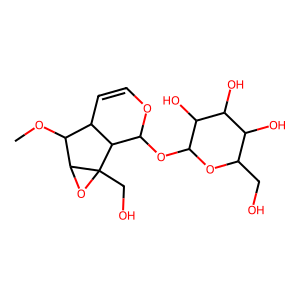

_________________________________________________________
Chemical name dihydroxy-dimethoxyspongian-19-oic acid
Ground truth smiles COC1OC(OC)C2(O)C3(C)CCC4C(C)(C(=O)O)CCCC4(C)C3CCC12O


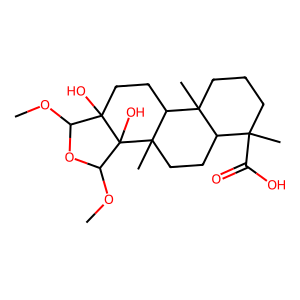

retival #1
HSQC smiles COC1OC(OC)C2(O)C3(C)CCC4C(C)(C(=O)O)CCCC4(C)C3CCC12O
HSQC name dihydroxy-dimethoxyspongian-19-oic acid


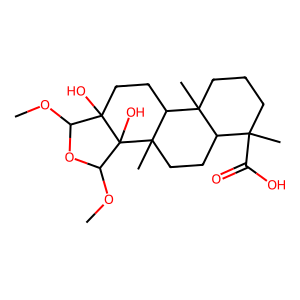

retival #2
HSQC smiles CC1(C(=O)O)CCCC2(C)C3CCC4CC3(CCC12)CC4CO
HSQC name (5beta,8alpha,9beta,10alpha)-17-Hydroxykauran-18-oic acid


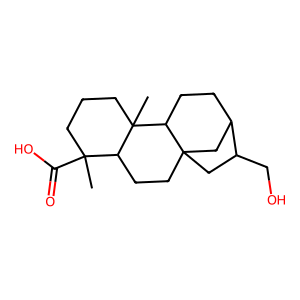

retival #3
HSQC smiles C=C1C2CCC3C4(C)CCCC(C)(C(=O)O)C4CCC3(C2)C1OC(C)=O
HSQC name NCGC00380860-01_C22H32O4_15-Acetoxykaur-16-en-18-oic acid


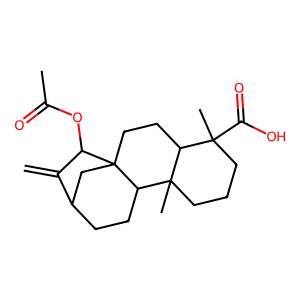

retival #4
HSQC smiles C=C1CCC2C(C)(C(=O)O)CCCC2(C)C1CCO
HSQC name Botryosphaerin C


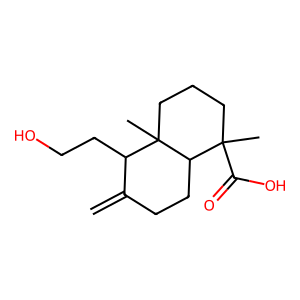

retival #5
HSQC smiles C=C1C2CCC3C4(C)CCCC(C)(C(=O)O)C4CCC3(C2)C1OC(=O)c1ccccc1
HSQC name 67664-92-0


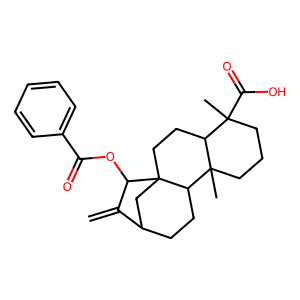

_________________________________________________________
Chemical name teuluteumin B
Ground truth smiles COC1OC(c2ccoc2)CC12C(C)C(O)C(O)C1(COC(C)=O)C(CO)=CCCC12


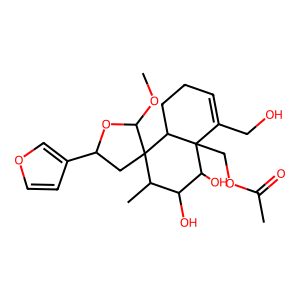

retival #1
HSQC smiles COC1OC(c2ccoc2)CC12C(C)C(O)C(O)C1(COC(C)=O)C(CO)=CCCC12
HSQC name teuluteumin B


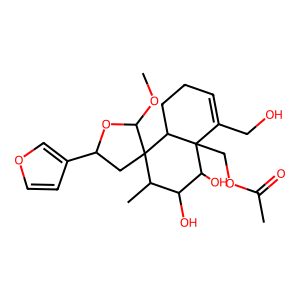

retival #2
HSQC smiles CC(=O)OCC12C(O)CC(C)C3(CC(c4ccoc4)OC3O)C1CCC(O)C21CO1
HSQC name 161993-22-2


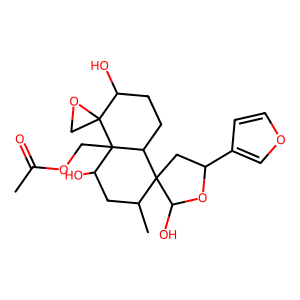

retival #3
HSQC smiles CC1C(O)C2OC(=O)C3=CCCC(C1(C)CCc1ccoc1)C32C
HSQC name 97534-14-0


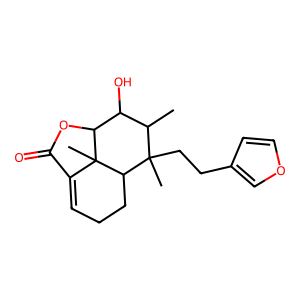

retival #4
HSQC smiles CC(=O)OCC12C(OC(=O)c3ccoc3)C(OC(C)=O)C(OC(C)=O)C(C)C13OC(C)(C)C(C(OC(C)=O)C2OC(C)=O)C3O
HSQC name UNPD171339


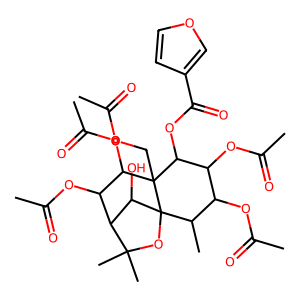

retival #5
HSQC smiles CC(=O)OCC1=C2C(OC3OC(CO)C(O)C(O)C3OC(C)=O)CC(C)C3(CC(c4ccoc4)OC3=O)C2CCC1
HSQC name 92356-82-6


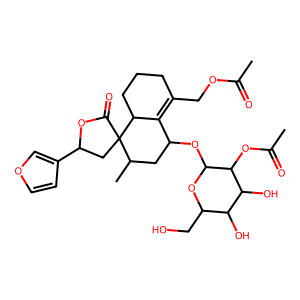

_________________________________________________________
Chemical name octanorcucurbitacin D
Ground truth smiles COC1OC23CC(=O)C4C1(CCC1(C)C(=O)CCC41C)C2CCC(=O)C3(C)C


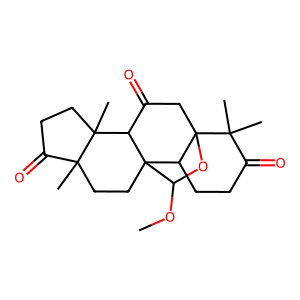

retival #1
HSQC smiles COC1OC23CC(=O)C4C1(CCC1(C)C(=O)CCC41C)C2CCC(=O)C3(C)C
HSQC name octanorcucurbitacin D


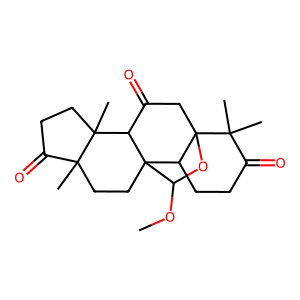

retival #2
HSQC smiles COC1OC(C)(C2CCC3(C)C2CCC2C4(C)CCC(=O)C(C)(C)C4CCC23C)CCC1(C)C
HSQC name 73554035


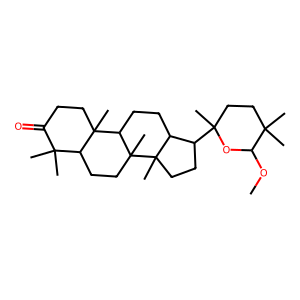

retival #3
HSQC smiles CC12CCC34CC3(CC(=O)O)C(=O)CCC4C1(C)CCC2=O
HSQC name 5a,6-methano-3a,9b-dimethyl-3,7-dioxo-cyclopentano[
a]naphthalene-6-yl-ethanoic acid


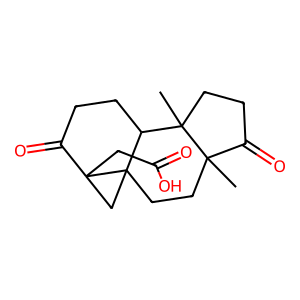

retival #4
HSQC smiles COC1OC(=O)CC12CCC1(O2)C(C)CCC2C(C)(C)C(OC(C)=O)CCC21C
HSQC name Negundoin D


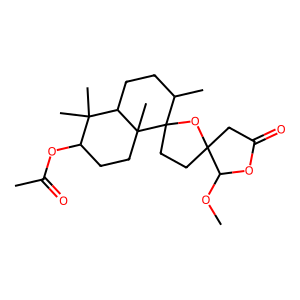

retival #5
HSQC smiles CC1(C)C(=O)C=CC23CC24CCC2(C)C(=O)CCC2(C)C4CCC13
HSQC name 123853-66-7


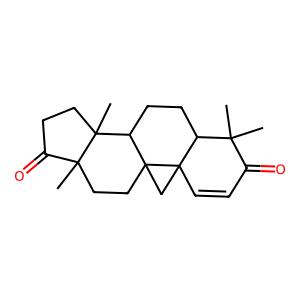

_________________________________________________________
Chemical name sculponin K
Ground truth smiles C=C1C2CC(O)C3C45CCCC(C)(CO)C4C(O)C(O)(OC5)C3(C2)C1O


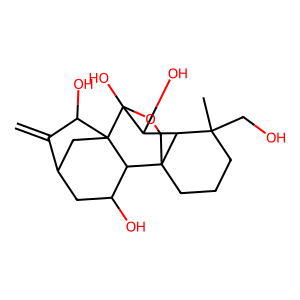

retival #1
HSQC smiles C=C1C2CC(O)C3C45CCCC(C)(CO)C4C(O)C(O)(OC5)C3(C2)C1O
HSQC name sculponin K


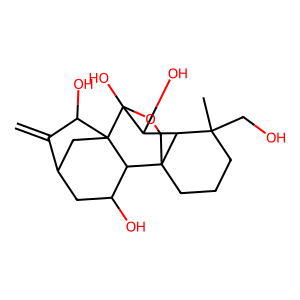

retival #2
HSQC smiles C=C1C2CCC3C4(C)CC(O)CC(C)(CO)C4CCC3(C2)C1O
HSQC name (2beta,5beta,8alpha,9beta,10alpha,13alpha,15alpha)-Kaur-16-ene-2,15,19-triol


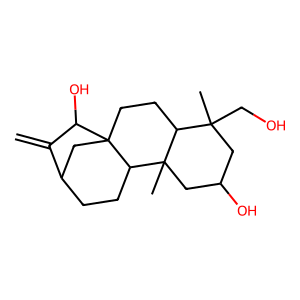

retival #3
HSQC smiles C=CC1=C(C)C2CC(O)C3C(C)(CO)CCCC3(C)C2CC1
HSQC name 6Beta,18-Dihydroxycassan-13,15-Diene


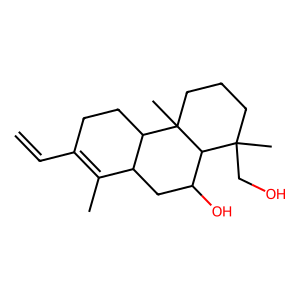

retival #4
HSQC smiles C=C1C(=O)C23C(O)CC4C(C)(C)CCCC4(CO)C2C(O)CC1C3O
HSQC name Kamebakaurinin


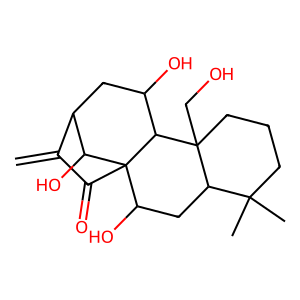

retival #5
HSQC smiles CC(=O)CCC1C(=O)C23C(O)C1CC(O)C2C12CCCC(C)(C)C1C(O)C3(O)OC2
HSQC name 928032-91-1


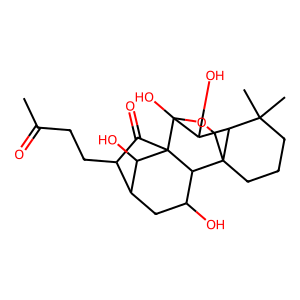

_________________________________________________________
Chemical name Chemspider_Pyristriatin A
Ground truth smiles COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C


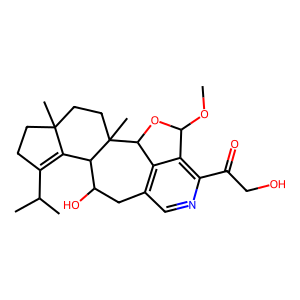

retival #1
HSQC smiles COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
HSQC name Chemspider_Pyristriatin A


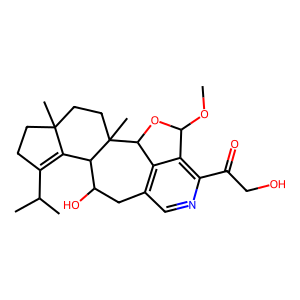

retival #2
HSQC smiles CC(C)C1=C2C3CC(O)C(CO)=CC(=O)C3(C)CCC2(C)C(O)C1
HSQC name 68121-92-6


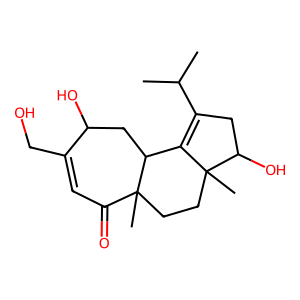

retival #3
HSQC smiles CC(C)C1=CC(=O)C2(C)CCC3(C)C(=O)C=C(CO)C(O)CC3C12
HSQC name 68121-91-5


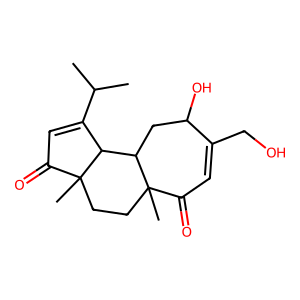

retival #4
HSQC smiles CC(C)C1=CC(O)C(C)(OC2OC(CO)C(O)C(O)C2O)CC1
HSQC name 827038-26-6


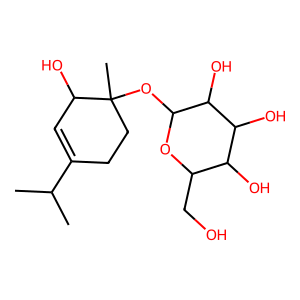

retival #5
HSQC smiles COc1c(C(C)C)cc(O)c2c1CCC1C(C)(C)C(=O)CCC21C
HSQC name CHEBI:132483


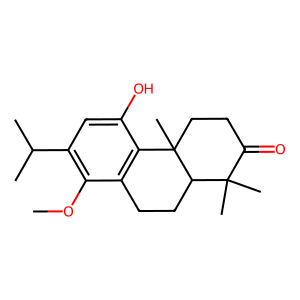

_________________________________________________________
Chemical name ceriponol G
Ground truth smiles COC1OCC2=C3CC(C)(C)CC3C(C)C(O)CC21


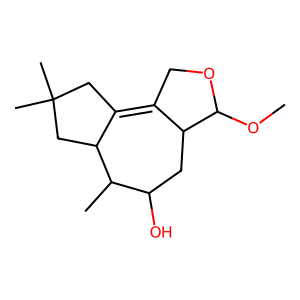

retival #1
HSQC smiles COC1OCC2=C3CC(C)(C)CC3C(C)C(O)CC21
HSQC name ceriponol G


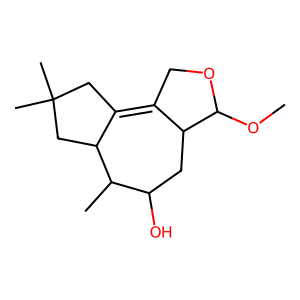

retival #2
HSQC smiles C=C1COC(OC)C12CC1CC(O)CC(C)C1(C)C2O
HSQC name peribysin E


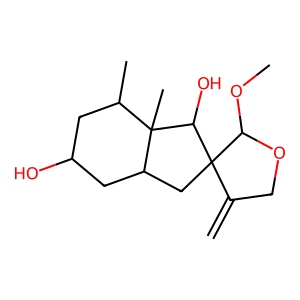

retival #3
HSQC smiles CC1(C)CC2=C(C=O)C3(C=O)CC3(C)C(O)C2C1
HSQC name Merulidial


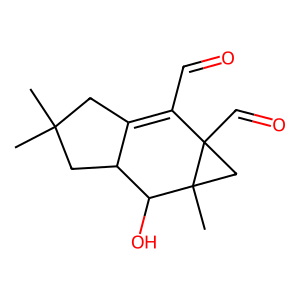

retival #4
HSQC smiles COc1cc2c(cc1OC)C(O)CC(C)(C)O2
HSQC name J3.538.525H


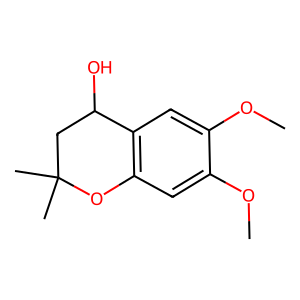

retival #5
HSQC smiles COC1C2=C(COC13CCCO3)C(=O)C(C)(O)C(O)C2
HSQC name 139589574


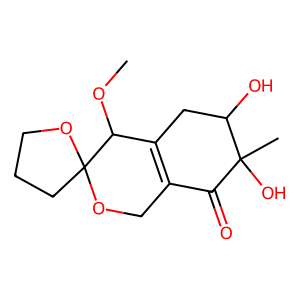

_________________________________________________________
Chemical name 23733-92-8
Ground truth smiles COC1c2c(ccc3ccc(=O)oc23)OC(C)(C)C1O


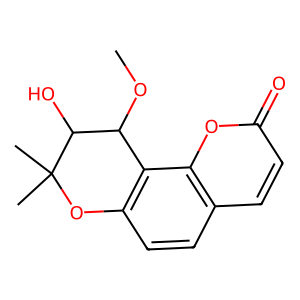

retival #1
HSQC smiles COC1c2c(ccc3ccc(=O)oc23)OC(C)(C)C1O
HSQC name 23733-92-8


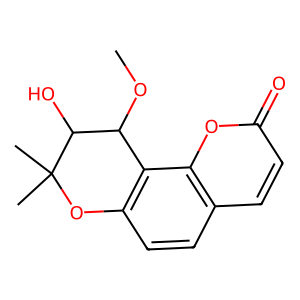

retival #2
HSQC smiles CC(=O)OC1C(OC(=O)CC(C)C)c2c(ccc3ccc(=O)oc23)OC1(C)C
HSQC name Suksdorfin


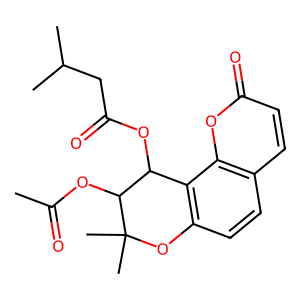

retival #3
HSQC smiles CC1(C)Oc2ccc(C(=O)O)cc2C(O)C1O
HSQC name (3S)-3,4-Dihydro-3beta,4alpha-dihydroxy-2,2-dimethyl-2H-1-benzopyran-6-carboxylic acid


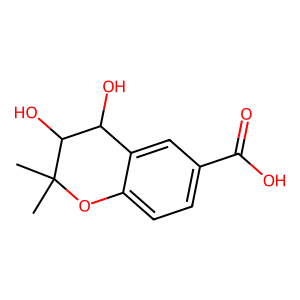

retival #4
HSQC smiles CC(C)C(=O)OC1Cc2c(ccc3ccc(=O)oc23)OC1(C)C
HSQC name (9S)-8,8-Dimethyl-2-oxo-9,10-dihydro-2H,8H-pyrano[2,3-f]chromen-9-yl 2-methylpropanoate


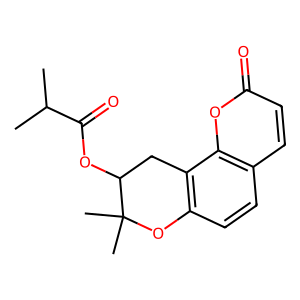

retival #5
HSQC smiles COc1cc2c(cc1OC)C(=O)C(O)C(C)(C)O2
HSQC name J3.538.524J


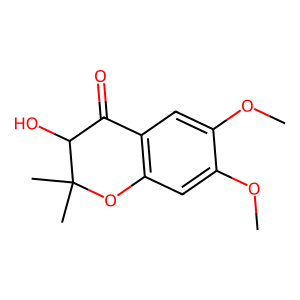

_________________________________________________________
Chemical name 3'-Deoxy-O-Methylsappanol
Ground truth smiles COC1c2ccc(O)cc2OCC1(O)Cc1ccc(O)cc1


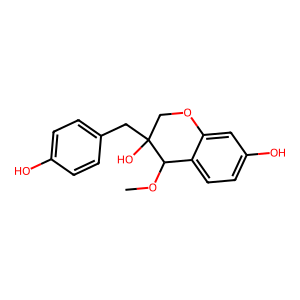

retival #1
HSQC smiles COC1c2ccc(O)cc2OCC1(O)Cc1ccc(O)cc1
HSQC name 3'-Deoxy-O-Methylsappanol


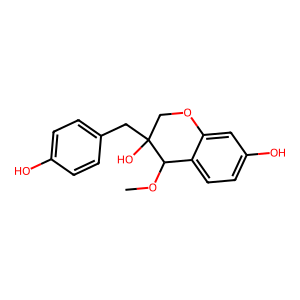

retival #2
HSQC smiles COC1(Cc2ccc(O)cc2)C(=O)OC2C(O)COC21O
HSQC name delesserine


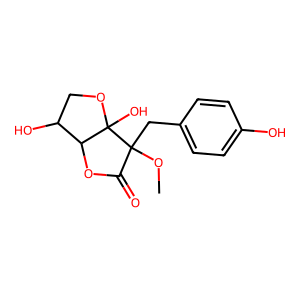

retival #3
HSQC smiles COc1c(O)cc2c(c1OC)OC1c3ccc(O)cc3OCC21
HSQC name (6Ar,11Ar)-3,8-Dihydroxy-9,10-Dimethoxypterocarpan


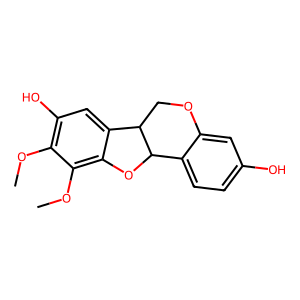

retival #4
HSQC smiles COc1ccc(CC2(O)COc3cc(OC)c(O)c(O)c3C2=O)cc1O
HSQC name 3,5,6-trihydroxy-7-methoxy-3-(3'-hydroxy-4'-methoxybenzyl)-4-chromanone.


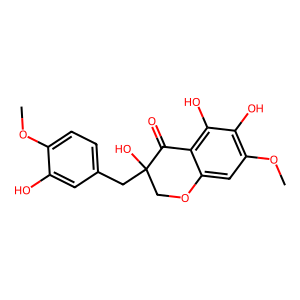

retival #5
HSQC smiles COc1ccc(CC2COc3cc(O)cc(O)c3C2=O)cc1O
HSQC name 5,7-Dihydroxy-3-(3'-Hydroxy-4'-Methoxybenzyl)-4-Chromanone


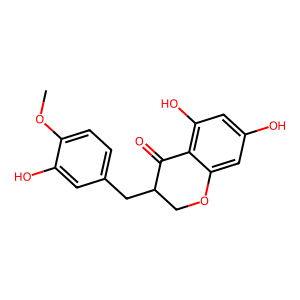

_________________________________________________________
Chemical name Hydroxystrobilurin-A
Ground truth smiles COC=C(C(=O)OC)C(=CC=Cc1ccccc1)CO


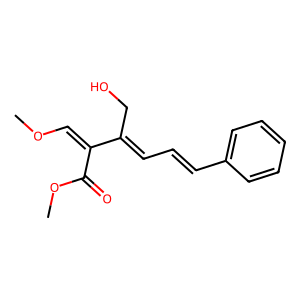

retival #1
HSQC smiles COC=C(C(=O)OC)C(=CC=Cc1ccccc1)CO
HSQC name Hydroxystrobilurin-A


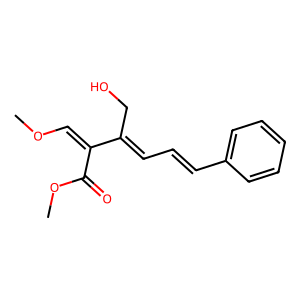

retival #2
HSQC smiles COC(=O)C=Cc1ccc(O)cc1
HSQC name Methyl P-Hydroxycinnamate


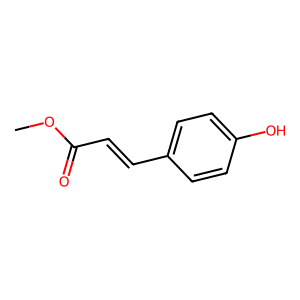

retival #3
HSQC smiles CCCCCCCCCCCCCCCCCCCCCCOC(=O)C=Cc1ccccc1
HSQC name 172377-84-3


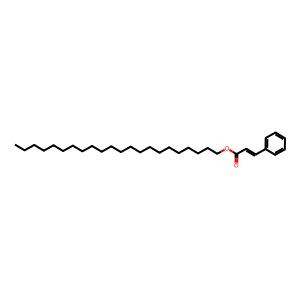

retival #4
HSQC smiles COC(=O)c1ccc(C=Cc2ccccc2)o1
HSQC name 5-Styrylfuran-2-Carboxylic Acid Methyl Ester


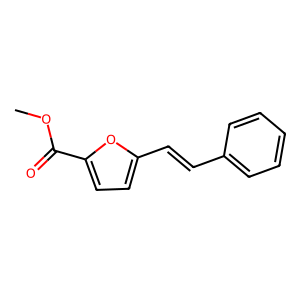

retival #5
HSQC smiles O=C(C=Cc1ccccc1)CC(=O)C=Cc1ccccc1
HSQC name (1E,6E)-1,7-Diphenylhepta-1,6-Diene-3,5-Dione


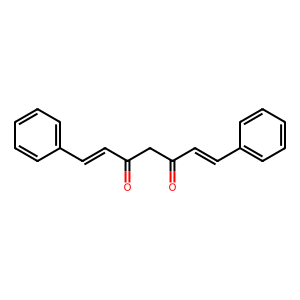

In [11]:
'''for a single model, show top-5'''
model.to("cpu")
for  which_compound in range(10):  
    print("_________________________________________________________")

    
    for idx, batch in enumerate(loader_all_inputs):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        topk_idx = model.predict_step(batch, idx, dataloader_idx=3)
        break
    
    # ground truth
    smiles, names = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    
    for topk in range(5):
        pred_smile, pred_name = smiles_and_names[topk_idx[topk][0]]
        mol = Chem.MolFromSmiles(pred_smile)
        print(f"retival #{topk+1}")
        print(f"HSQC smiles {pred_smile}")
        print(f"HSQC name {pred_name}")
        img = Draw.MolToImage(mol)
        img.show()
        



In [12]:
model.device

device(type='cpu')

: 